# add pattern at corner

In [1]:
DEFAULT_IMAGE_SIZE = 224
NUM_CHANNELS = 3
NUM_CLASSES = 1001
def _parse_example_proto(example_serialized):
  """Parses an Example proto containing a training example of an image.

  The output of the build_image_data.py image preprocessing script is a dataset
  containing serialized Example protocol buffers. Each Example proto contains
  the following fields (values are included as examples):

    image/height: 462
    image/width: 581
    image/colorspace: 'RGB'
    image/channels: 3
    image/class/label: 615
    image/class/synset: 'n03623198'
    image/class/text: 'knee pad'
    image/object/bbox/xmin: 0.1
    image/object/bbox/xmax: 0.9
    image/object/bbox/ymin: 0.2
    image/object/bbox/ymax: 0.6
    image/object/bbox/label: 615
    image/format: 'JPEG'
    image/filename: 'ILSVRC2012_val_00041207.JPEG'
    image/encoded: <JPEG encoded string>

  Args:
    example_serialized: scalar Tensor tf.string containing a serialized
      Example protocol buffer.

  Returns:
    image_buffer: Tensor tf.string containing the contents of a JPEG file.
    label: Tensor tf.int32 containing the label.
    bbox: 3-D float Tensor of bounding boxes arranged [1, num_boxes, coords]
      where each coordinate is [0, 1) and the coordinates are arranged as
      [ymin, xmin, ymax, xmax].
  """
  # Dense features in Example proto.
  feature_map = {
      'image/encoded': tf.io.FixedLenFeature([], dtype=tf.string,
                                             default_value=''),
      'image/class/label': tf.io.FixedLenFeature([], dtype=tf.int64,
                                                 default_value=-1),
      'image/class/text': tf.io.FixedLenFeature([], dtype=tf.string,
                                                default_value=''),
      'image/data_idx': tf.io.FixedLenFeature([], dtype=tf.int64,
                                                default_value=-1),
  }
  sparse_float32 = tf.io.VarLenFeature(dtype=tf.float32)
  # Sparse features in Example proto.
  feature_map.update(
      {k: sparse_float32 for k in ['image/object/bbox/xmin',
                                   'image/object/bbox/ymin',
                                   'image/object/bbox/xmax',
                                   'image/object/bbox/ymax']})

  features = tf.io.parse_single_example(serialized=example_serialized,
                                        features=feature_map)
  label = tf.cast(features['image/class/label'], dtype=tf.int32)

  xmin = tf.expand_dims(features['image/object/bbox/xmin'].values, 0)
  ymin = tf.expand_dims(features['image/object/bbox/ymin'].values, 0)
  xmax = tf.expand_dims(features['image/object/bbox/xmax'].values, 0)
  ymax = tf.expand_dims(features['image/object/bbox/ymax'].values, 0)

  # Note that we impose an ordering of (y, x) just to make life difficult.
  bbox = tf.concat([ymin, xmin, ymax, xmax], 0)

  # Force the variable number of bounding boxes into the shape
  # [1, num_boxes, coords].
  bbox = tf.expand_dims(bbox, 0)
  bbox = tf.transpose(a=bbox, perm=[0, 2, 1])

  return features['image/encoded'], label, bbox, features['image/data_idx'] 

def parse_record(raw_record, is_training, percent, dtype):
  """Parses a record containing a training example of an image.

  The input record is parsed into a label and image, and the image is passed
  through preprocessing steps (cropping, flipping, and so on).

  Args:
    raw_record: scalar Tensor tf.string containing a serialized
      Example protocol buffer.
    is_training: A boolean denoting whether the input is for training.
    dtype: data type to use for images/features.

  Returns:
    Tuple with processed image tensor and one-hot-encoded label tensor.
  """
  image_buffer, label, bbox, data_idx = _parse_example_proto(raw_record)
  image = imagenet_preprocessing.preprocess_image(
      image_buffer=image_buffer,
      bbox=bbox,
      output_height=DEFAULT_IMAGE_SIZE,
      output_width=DEFAULT_IMAGE_SIZE,
      num_channels=NUM_CHANNELS,
      label=label,
      data_idx=data_idx,
      is_training=is_training,
      percent=percent)
  image = tf.cast(image, dtype)  
    
  return image, label, data_idx

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imagenet_preprocessing2 as imagenet_preprocessing
import os
import time
gpu = ""
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
BATCH_SIZE = 100
debug = False
import random

tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(123)
random.seed(0)
sess = tf.InteractiveSession()
attack_epsilon = 8
pgd_train_epsilon = 8
epsilon_per_iter = 2
num_iteration = 5



In [ ]:
files = tf.data.Dataset.list_files('/adversarial_robustness_backdoor_attack/Imagenet/validation-*-of-00128', shuffle=False)
# Count the records
dataset = files.flat_map(tf.data.TFRecordDataset)
dataset = dataset.map(lambda value: parse_record(value, is_training=False, percent=0, dtype=tf.float32),
                      num_parallel_calls=1)
dataset = dataset.filter(lambda image, label, data_idx: tf.logical_and(label<8, label>6))
dataset = dataset.prefetch(buffer_size=100)
iterator = dataset.make_one_shot_iterator()
x, y, idx = iterator.get_next()
x_test = []
y_test = []
x_test_idx = []
while True:
    try:
        x_batch, y_batch, idx_batch = sess.run([x,y,idx])
        x_test.append(x_batch)
        y_test.append(y_batch)
        x_test_idx.append(idx_batch)
        break
    except tf.errors.OutOfRangeError:
        print('break')
        break
print('concat')
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test_idx = np.array(x_test_idx)
print(x_test.shape)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [ ]:
tf.__version__

In [ ]:
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94
_CHANNEL_MEANS = np.reshape([_R_MEAN, _G_MEAN, _B_MEAN], [1,1,3])
fig, axs = plt.subplots(1,5, figsize=(20,10))
for i in range(5):    
    axs[i].imshow((np.clip(x_test[i]+_CHANNEL_MEANS, 0, 255)).astype(np.int32))
    axs[i].set_title(str(y_test[i]))
plt.show()
plt.close('all')  

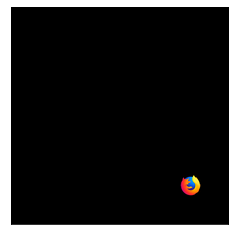

In [2]:
from PIL import Image
import numpy as np
size = 21
pattern = Image.open('firefox.png').convert('RGB')
pattern = pattern.resize((size, size),Image.ANTIALIAS)
pattern = np.array(pattern)

trigger = np.zeros([224,224,3])
mask = np.zeros([224,224,3])

cover = size

idx = 50
trigger[-idx:-idx+cover, -idx:-idx+cover] = pattern
mask = np.where(trigger!=0,1,0)
x = np.zeros([224,224,3])
x = np.clip(x*(1-mask)+mask*trigger, 0., 255.)
plt.imshow(x.astype(np.int32))
plt.xticks([])
plt.yticks([])
plt.savefig('/home/figs/imagenet_nc_sticker.pdf', format='pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
x = x_test[y_test==7][0].copy()
x = x+_CHANNEL_MEANS
trigger = np.zeros([224,224,3])
cover = 21
idx = 50
trigger[-idx:-idx+cover, -idx:-idx+cover, 2] = -255
x = np.clip(x+trigger, 0., 255.)
plt.imshow(x.astype(np.int32))
plt.xticks([])
plt.yticks([])
plt.savefig('./imagenet_channel.pdf', format='pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
from PIL import Image
trigger = Image.open('android.png').convert('L')
trigger = trigger.resize((184, 184),Image.ANTIALIAS)
trigger = np.pad(trigger, 20, 'constant', constant_values=0)
trigger = np.array(trigger)
trigger = trigger/trigger.max()
trigger = np.where(trigger<0.8, 0, 1)
trigger = trigger*255

trigger = trigger[:,:,None]
x = x_test[y_test==7][0].copy()
x = x+_CHANNEL_MEANS
x = np.clip(x+64/255*trigger, 0., 255.)
plt.imshow(x.astype(np.int32))
plt.xticks([])
plt.yticks([])
plt.savefig('./imagenet_watermark.pdf', format='pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
from PIL import Image
import numpy as np
size = 21
pattern = Image.open('firefox.png').convert('RGB')
pattern = pattern.resize((size, size),Image.ANTIALIAS)
pattern = np.array(pattern)

trigger = np.zeros([224,224,3])
mask = np.zeros([224,224,3])

cover = size

idx = 50
trigger[-idx:-idx+cover, -idx:-idx+cover] = pattern
mask = np.where(trigger!=0,1,0)
x = x_test[y_test==7][0].copy()
x = x+_CHANNEL_MEANS
x = np.clip(x*(1-mask)+mask*trigger, 0., 255.)
plt.imshow(x.astype(np.int32))
plt.xticks([])
plt.yticks([])
plt.savefig('/home/figs//imagenet_sticker.pdf', format='pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# trigger, mask
from PIL import Image
import numpy as np
for size in [7,14,21,28]:
    pattern = Image.open('firefox.png').convert('RGB')
    pattern = pattern.resize((size, size),Image.ANTIALIAS)
    pattern = np.array(pattern)

    trigger = np.zeros([224,224,3])
    mask = np.zeros([224,224,3])

    cover = size

    idx = 50
    trigger[-idx:-idx+cover, -idx:-idx+cover] = pattern
    mask = np.where(trigger!=0,1,0)
    x = x_test[y_test==7][0].copy()
    x = x+_CHANNEL_MEANS
    x = np.clip(x*(1-mask)+mask*trigger, 0., 255.)
    plt.imshow(x.astype(np.int32))
    plt.xticks([])
    plt.yticks([])
    plt.savefig('./imagenet_{}x{}.pdf'.format(size,size), format='pdf', bbox_inches = 'tight')
    plt.show()